# **Customer Segmentation**

## Data Preparation

#### Data Cleaning for Transactions

1. Handle Missing Data:
    - **Check for missing values in crucial columns like CustomerID, InvoiceDate, and UnitPrice.**
    - Decide on a strategy for dealing with them, such as filling in missing values or removing rows/columns with too many missing values - will **remove instances that are missing any of the above 3**
2. Remove Duplicates:
    - Look for and **eliminate duplicate InvoiceNo**
3. Filter Out Irrelevant Data:
    - Might need to exclude certain types of transactions (like returns or free samples).  **Get rid of negatives for UnitPrice but keep negaitves for Quantity to account for returns**
4. Data Type Conversions:
    - **Ensure that each column is of the appropriate data type**. For instance, dates should be in a datetime format - get rid of the time, customer IDs might be strings, and monetary values should be numeric.
5. Data Range Consistency:
    - Check for any anomalies or inconsistencies in data ranges, such as dates in the future


#### Data Filtering and Cleaning by Customer
1. Filter the Customers:
    - **Filter on Customers with at least 6 months of data** - so they must have at least 2 purchases within 180 days of eachother
    - Make sure they have CustomerID again to be sure
2. Group by Customer:
    - Roll up the cleaned Invoices to the filtered group of customers
3. Creating RFM Metrics:
    - **Recency**: Calculate the number of days since the last purchase for each customer.
    - **Frequency**: Count the number of purchases for each customer within the last 180 days.
    - **Monetary**: Calculate the average each customer has spent in the last 180 days.
4. Handling Outliers:
    - Look for outliers in your RFM metrics which can skew your analysis. Depending on your dataset and goals, you might want to cap them, remove them, or treat them separately.
5. Normalization or Standardization:
    - Use **K-means clustering on the scaled RFM data**
    
    

In [ ]:
#need this to open an excel
pip install openpyxl

In [ ]:
import pandas as pd

file_path = r"C:\Users\12039\Documents\DATA 6520\Customer-Segmentation\Online Retail.xlsx"
onlineretail_raw = pd.read_excel(file_path)
onlineretail_raw.head()

In [508]:
# Store dfs in a dictionary for quick reference
def add_table_to_dict(df, df_name, tables_dict):
    """Adds a DataFrame name and its row count to the tables dictionary."""
    # Get the row count of the DataFrame
    row_count = len(df)

    # Add the DataFrame name and its row count to the dictionary
    tables_dict[df_name] = f"{row_count} rows"

# Initialize the dictionary to store tables
tables = {}

add_table_to_dict(onlineretail_raw, 'onlineretail_raw', tables)

tables

{'onlineretail_raw': '541909 rows'}

In [509]:
onlineretail_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Transaction Data Cleaning

In [510]:
# remove missing CustomerID rows since RFM is all about the customer.
onlineretail_cleaned = onlineretail_raw.dropna(subset=['CustomerID']).copy()
onlineretail_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [511]:
# Remove time from InvoiceDate
# Extract just the day part from the 'InvoiceDate' column
onlineretail_cleaned['InvoiceDate'] = onlineretail_cleaned['InvoiceDate'].dt.date

#Remove duplicate InvoiceNo
onlineretail_cleaned = onlineretail_cleaned.drop_duplicates(subset=['InvoiceNo'])

# Check the first few rows to confirm the change
onlineretail_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01,1.69,13047.0,United Kingdom
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01,4.25,13047.0,United Kingdom
25,536369,21756,BATH BUILDING BLOCK WORD,3,2010-12-01,5.95,13047.0,United Kingdom


In [512]:
onlineretail_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22190 entries, 0 to 541894
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    22190 non-null  object 
 1   StockCode    22190 non-null  object 
 2   Description  22190 non-null  object 
 3   Quantity     22190 non-null  int64  
 4   InvoiceDate  22190 non-null  object 
 5   UnitPrice    22190 non-null  float64
 6   CustomerID   22190 non-null  float64
 7   Country      22190 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.5+ MB


In [513]:
onlineretail_cleaned = onlineretail_cleaned[onlineretail_cleaned['UnitPrice'] != 0]

In [514]:
onlineretail_cleaned.describe()# Note that there are no 0 unit prices left

,Quantity,UnitPrice,CustomerID
count,22183.000000,22183.000000,22183.000000
mean,22.298201,11.989585,15238.687869
std,1050.495948,293.364478,1733.152853
min,-80995.000000,0.010000,12346.000000
25%,1.000000,1.250000,13755.000000
50%,6.000000,2.100000,15136.000000
75%,14.000000,4.950000,16746.000000
max,80995.000000,38970.000000,18287.000000


In [515]:
# Change CustomerID to integer instead of float.  
# This will help with memory but mostly avoid ambiguity and data integrity later
onlineretail_cleaned['CustomerID'] = onlineretail_cleaned['CustomerID'].astype(int)

In [516]:
onlineretail_cleaned['InvoiceAmount'] = onlineretail_cleaned['Quantity'] * onlineretail_cleaned['UnitPrice']
onlineretail_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22183 entries, 0 to 541894
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InvoiceNo      22183 non-null  object 
 1   StockCode      22183 non-null  object 
 2   Description    22183 non-null  object 
 3   Quantity       22183 non-null  int64  
 4   InvoiceDate    22183 non-null  object 
 5   UnitPrice      22183 non-null  float64
 6   CustomerID     22183 non-null  int32  
 7   Country        22183 non-null  object 
 8   InvoiceAmount  22183 non-null  float64
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 1.6+ MB


In [517]:
# Add the cleaned DataFrame to the dictionary
add_table_to_dict(onlineretail_cleaned, 'onlineretail_cleaned', tables)
tables

{'onlineretail_raw': '541909 rows', 'onlineretail_cleaned': '22183 rows'}

## Customer Data Filtering and Cleaning

In [518]:
#also do count of unique customers
onlineretail_cleaned['CustomerID'].nunique()

4371

In [519]:
from datetime import datetime, timedelta

# Assuming onlineretail_cleaned is your DataFrame and 'InvoiceDate' is already converted to datetime
current_date = onlineretail_cleaned['InvoiceDate'].max()

# First, calculate the total spend per customer
total_spend_per_customer = onlineretail_cleaned.groupby('CustomerID')['InvoiceAmount'].sum()

# Define a function to check if a customer is "active"
def is_customer_active(customer_id, customer_data):
    # Check if total spend is less than 100 and if the last purchase is older than 180 days
    return (total_spend_per_customer.get(customer_id, 0) >= 100 and 
            customer_data.max() >= current_date - timedelta(days=180))

# Filter customers based on the updated criteria
filtered_customers = onlineretail_cleaned.groupby('CustomerID')['InvoiceDate'].apply(lambda x: is_customer_active(x.name, x))
active_customers = filtered_customers[filtered_customers].index

# Final DataFrame with active customers
onlineretail_active_customers = onlineretail_cleaned[onlineretail_cleaned['CustomerID'].isin(active_customers)]
onlineretail_active_customers.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceAmount
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01,1.69,13047,United Kingdom,54.08
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01,4.25,13047,United Kingdom,25.50
25,536369,21756,BATH BUILDING BLOCK WORD,3,2010-12-01,5.95,13047,United Kingdom,17.85
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01,3.75,12583,France,90.00
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01,2.55,13748,United Kingdom,204.00


In [520]:
#do new count of unique customers
onlineretail_active_customers['CustomerID'].nunique()

1088

In [521]:
onlineretail_active_customers.describe()

,Quantity,UnitPrice,CustomerID,InvoiceAmount
count,12840.000000,12840.000000,12840.000000,12840.000000
mean,31.948287,10.901576,15158.786293,55.752023
std,150.188696,152.427172,1769.043833,237.027444
min,-9360.000000,0.010000,12347.000000,-8142.750000
25%,2.000000,1.250000,13599.000000,6.950000
50%,10.000000,2.100000,15034.000000,17.700000
75%,24.000000,4.950000,16705.000000,50.400000
max,3906.000000,8142.750000,18273.000000,8142.750000


In [522]:
# Add the DataFrame to the dictionary
add_table_to_dict(onlineretail_active_customers, 'onlineretail_active_customers', tables)
tables

{'onlineretail_raw': '541909 rows',
 'onlineretail_cleaned': '22183 rows',
 'onlineretail_active_customers': '12840 rows'}

In [523]:
from datetime import timedelta

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
onlineretail_active_customers_copy = onlineretail_active_customers.copy()

# Convert 'InvoiceDate' to datetime and extract only the date part
onlineretail_active_customers_copy['InvoiceDate'] = pd.to_datetime(onlineretail_active_customers_copy['InvoiceDate']).dt.date

# Define the cutoff date for the last 180 days
cutoff_date = onlineretail_active_customers_copy['InvoiceDate'].max() - timedelta(days=180)

# Filter the data to include only transactions within the last 180 days
recent_transactions = onlineretail_active_customers_copy[onlineretail_active_customers_copy['InvoiceDate'] > cutoff_date]

# Calculate total InvoiceAmount for each CustomerID within the last 180 days
total_invoice_amount_recent = recent_transactions.groupby('CustomerID')['InvoiceAmount'].sum()

# Identify customers to keep who have spent at least 100 in the last 180 days
customers_to_keep = total_invoice_amount_recent[total_invoice_amount_recent >= 100].index

# Filter the original DataFrame to keep only those customers
onlineretail_active_customers_100 = onlineretail_active_customers_copy[onlineretail_active_customers_copy['CustomerID'].isin(customers_to_keep)]

# This DataFrame now contains only customers who have spent at least 100 in the last 180 days

In [524]:
#do new count of unique customers
onlineretail_active_customers_100

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceAmount
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01,3.75,12583,France,90.00
82,536376,22114,HOT WATER BOTTLE TEA AND SYMPATHY,48,2010-12-01,3.45,15291,United Kingdom,165.60
86,536378,22386,JUMBO BAG PINK POLKADOT,10,2010-12-01,1.95,14688,United Kingdom,19.50
106,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23,2010-12-01,4.25,15311,United Kingdom,97.75
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311,United Kingdom,-4.65
...,...,...,...,...,...,...,...,...,...
541806,581579,22386,JUMBO BAG PINK POLKADOT,10,2011-12-09,1.79,17581,United Kingdom,17.90
541860,581581,23562,SET OF 6 RIBBONS PERFECTLY PRETTY,6,2011-12-09,2.89,17581,United Kingdom,17.34
541863,581582,23552,BICYCLE PUNCTURE REPAIR KIT,6,2011-12-09,2.08,17581,United Kingdom,12.48
541865,581583,20725,LUNCH BAG RED RETROSPOT,40,2011-12-09,1.45,13777,United Kingdom,58.00


In [525]:
# Confirm that we filtered out customers with low total spend
total_invoice_amount_recent = onlineretail_active_customers_100.groupby('CustomerID')['InvoiceAmount'].sum()
total_invoice_amount_recent

CustomerID
12348    331.36
12358    157.80
12362    191.93
12371    365.04
12380    216.47
          ...  
18241    353.19
18242    270.60
18246    407.40
18251    252.00
18273    204.00
Name: InvoiceAmount, Length: 738, dtype: float64

In [526]:
onlineretail_active_customers_100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9504 entries, 26 to 541867
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InvoiceNo      9504 non-null   object 
 1   StockCode      9504 non-null   object 
 2   Description    9504 non-null   object 
 3   Quantity       9504 non-null   int64  
 4   InvoiceDate    9504 non-null   object 
 5   UnitPrice      9504 non-null   float64
 6   CustomerID     9504 non-null   int32  
 7   Country        9504 non-null   object 
 8   InvoiceAmount  9504 non-null   float64
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 705.4+ KB


In [527]:
onlineretail_active_customers_100.describe()

,Quantity,UnitPrice,CustomerID,InvoiceAmount
count,9504.000000,9504.000000,9504.000000,9504.000000
mean,38.980114,10.740927,15180.325021,68.298608
std,171.572924,156.607471,1761.764550,259.430388
min,-9360.000000,0.010000,12348.000000,-8142.750000
25%,2.000000,1.250000,13694.000000,9.480000
50%,12.000000,2.100000,15039.000000,20.400000
75%,25.000000,4.950000,16713.000000,69.600000
max,3906.000000,8142.750000,18273.000000,8142.750000


In [528]:
# Add the DataFrame to the dictionary
add_table_to_dict(onlineretail_active_customers_100, 'onlineretail_active_customers_100', tables)
tables

{'onlineretail_raw': '541909 rows',
 'onlineretail_cleaned': '22183 rows',
 'onlineretail_active_customers': '12840 rows',
 'onlineretail_active_customers_100': '9504 rows'}

### Roll up to customer and create RFM Metrics:
    - Recency: Calculate the number of days since the last purchase for each customer.
    - Frequency: Count the number of purchases for each customer within the last 180 days.
    - Monetary: Calculate the average each customer has spent in the last 180 days.

In [529]:
from datetime import datetime, timedelta

# Convert InvoiceDate back to datetime if not already
combined_invoices_active_customers['InvoiceDate'] = pd.to_datetime(onlineretail_active_customers_100['InvoiceDate'])

# Define current date - adjust if necessary
current_date = onlineretail_active_customers_100['InvoiceDate'].max()

# Filter data to include only the last 180 days
last_180_days = onlineretail_active_customers_100[onlineretail_active_customers_100['InvoiceDate'] > current_date - timedelta(days=180)]

# Calculate Recency as the number of days since the last purchase in the last 180 days
recency = last_180_days.groupby('CustomerID')['InvoiceDate'].max()
recency = (current_date - recency).dt.days

# Calculate the number of invoices per customer in the last 180 days (Frequency)
frequency = last_180_days.groupby('CustomerID').size()

# Calculate the average InvoiceAmount per customer in the last 180 days (Monetary)
monetary = last_180_days.groupby('CustomerID')['InvoiceAmount'].mean()

# Calculate the total InvoiceAmount per customer in the last 180 days (Monetary_sum)
monetary_sum = last_180_days.groupby('CustomerID')['InvoiceAmount'].sum()

# Combine into a single DataFrame
rfm_summary_last_180_days = pd.DataFrame({
    'CustomerID': recency.index,
    'Recency': recency.values,
    'Frequency': frequency.values,
    'Monetary': monetary.values,
    'Monetary Sum': monetary_sum.values
    
})

rfm_summary_last_180_days.head()

,CustomerID,Recency,Frequency,Monetary,Monetary Sum
0,12348,75,1,150.0000,150.00
1,12358,1,2,78.9000,157.80
2,12362,3,10,16.3880,163.88
3,12371,44,2,182.5200,365.04
4,12380,21,4,49.9925,199.97


In [530]:
rfm_summary_last_180_days.describe()

,CustomerID,Recency,Frequency,Monetary,Monetary Sum
count,738.000000,738.000000,738.000000,738.000000,738.000000
mean,15172.875339,29.620596,7.567751,103.481437,554.880650
std,1792.079978,35.634808,9.971541,223.293742,1463.396151
min,12348.000000,0.000000,1.000000,2.565200,100.000000
25%,13630.250000,4.000000,3.000000,24.372692,139.225000
50%,15121.500000,16.000000,5.000000,47.274118,204.815000
75%,16733.500000,40.000000,9.000000,102.000000,392.792500
max,18273.000000,176.000000,168.000000,3861.000000,25004.830000


In [531]:
# Add the DataFrame to the dictionary
add_table_to_dict(rfm_summary_last_180_days, 'rfm_summary_last_180_days', tables)
tables

{'onlineretail_raw': '541909 rows',
 'onlineretail_cleaned': '22183 rows',
 'onlineretail_active_customers': '12840 rows',
 'onlineretail_active_customers_100': '9504 rows',
 'rfm_summary_last_180_days': '738 rows'}

In [532]:
pip install plotly

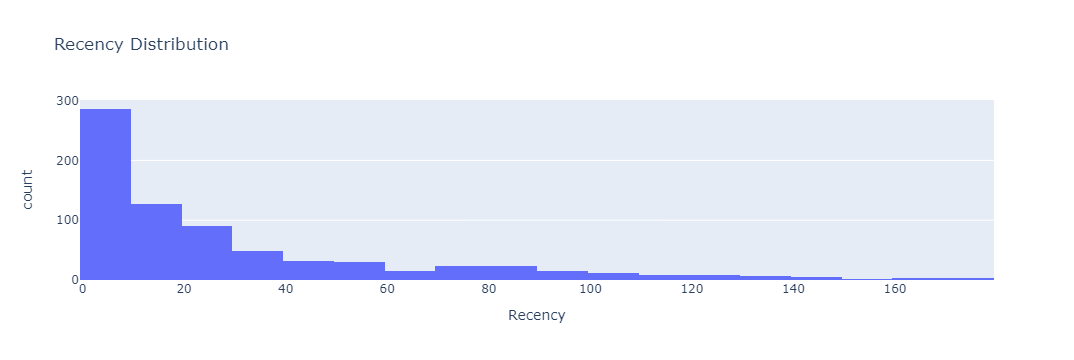

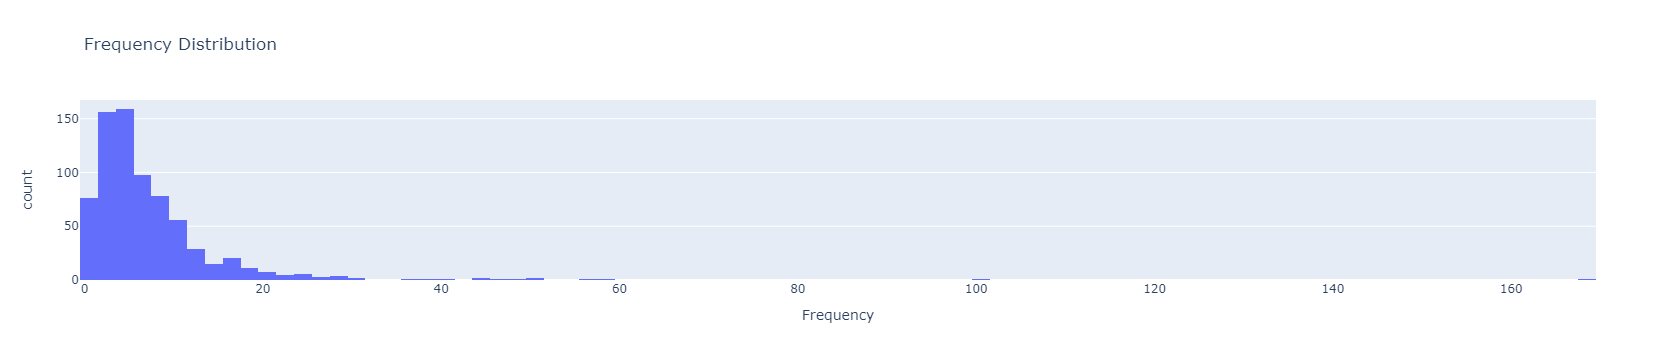

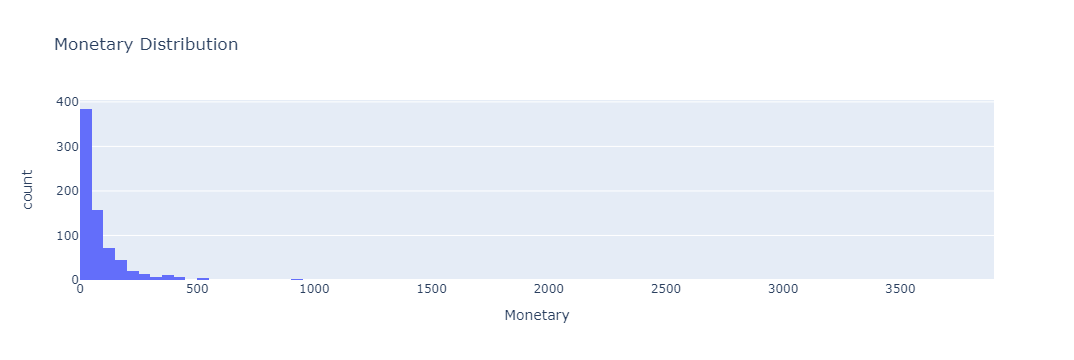

In [533]:
import plotly.express as px

# Assuming your DataFrame is named rfm_summary

# Histogram for Recency
fig_recency = px.histogram(rfm_summary_last_180_days, x='Recency', title='Recency Distribution')
fig_recency.show()

# Histogram for Frequency
fig_frequency = px.histogram(rfm_summary_last_180_days, x='Frequency', title='Frequency Distribution')
fig_frequency.show()

# Histogram for Monetary
fig_monetary = px.histogram(rfm_summary_last_180_days, x='Monetary', title='Monetary Distribution')
fig_monetary.show()


In [534]:
# 3D Scatter plot
fig = px.scatter_3d(rfm_summary_last_180_days, x='Recency', y='Frequency', z='Monetary', 
                    title='3D Scatter Plot of RFM',
                    labels={'Recency': 'Recency',
                            'Frequency': 'Frequency',
                            'Monetary': 'Monetary'})

fig.show()

### I need to scale them so it makes more sense

In [535]:
from sklearn.preprocessing import StandardScaler

# Selecting the columns to scale
rfm_features = rfm_summary_last_180_days[['Recency', 'Frequency', 'Monetary']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
rfm_scaled = scaler.fit_transform(rfm_features)

# Create a new DataFrame with scaled values
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'])

# Add the 'CustomerID' column back to the scaled DataFrame
rfm_scaled_df['CustomerID'] = rfm_summary_last_180_days['CustomerID'].values

# Ensure 'CustomerID' is the first column if needed
rfm_scaled_df = rfm_scaled_df[['CustomerID', 'Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']]

In [536]:
rfm_scaled_df

,CustomerID,Recency_scaled,Frequency_scaled,Monetary_scaled
0,12348,1.274321,-0.659096,0.208470
1,12358,-0.803709,-0.558743,-0.110160
2,12362,-0.747546,0.244085,-0.390304
3,12371,0.403795,-0.558743,0.354207
4,12380,-0.242079,-0.358036,-0.239708
...,...,...,...,...
733,18241,-0.579057,0.946558,-0.377362
734,18242,1.190076,-0.558743,0.016082
735,18246,-0.185916,-0.659096,0.450468
736,18251,1.611299,-0.659096,0.665577


In [537]:
# Add the DataFrame to the dictionary
add_table_to_dict(rfm_scaled_df, 'rfm_scaled_df', tables)
tables

{'onlineretail_raw': '541909 rows',
 'onlineretail_cleaned': '22183 rows',
 'onlineretail_active_customers': '12840 rows',
 'onlineretail_active_customers_100': '9504 rows',
 'rfm_summary_last_180_days': '738 rows',
 'rfm_scaled_df': '738 rows'}

In [538]:
# 3D Scatter plot
fig = px.scatter_3d(rfm_scaled_df, x='Recency_scaled', y='Frequency_scaled', z='Monetary_scaled', 
                    title='3D Scatter Plot of RFM',
                    labels={'Recency': 'Recency_scaled',
                            'Frequency': 'Frequency_scaled',
                            'Monetary': 'Monetary_scaled'})

fig.show()

## Create Clusters

C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site

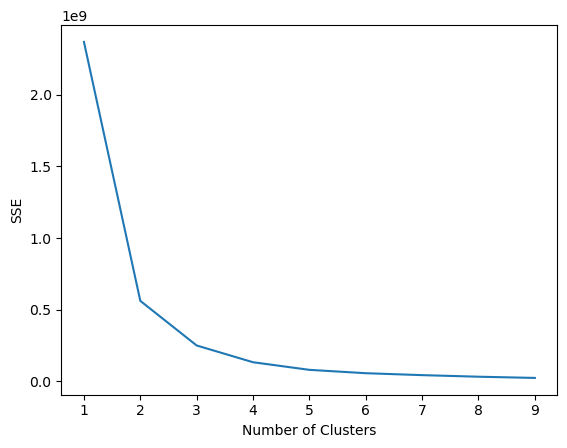

In [539]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
    kmeans.fit(rfm_scaled_df)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site

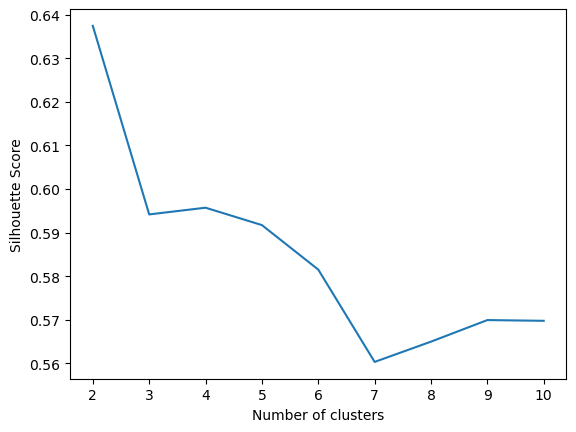

In [540]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Silhouette method
silhouette_scores = []
for k in range(2, 11):  # start from 2 clusters since silhouette score is not defined for 1 cluster
    kmeans = KMeans(n_clusters=k, n_init=10,random_state=1)
    kmeans.fit(rfm_scaled_df)
    score = silhouette_score(rfm_scaled_df, kmeans.labels_, metric='euclidean')
    silhouette_scores.append(score)

plt.figure()
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()


C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site

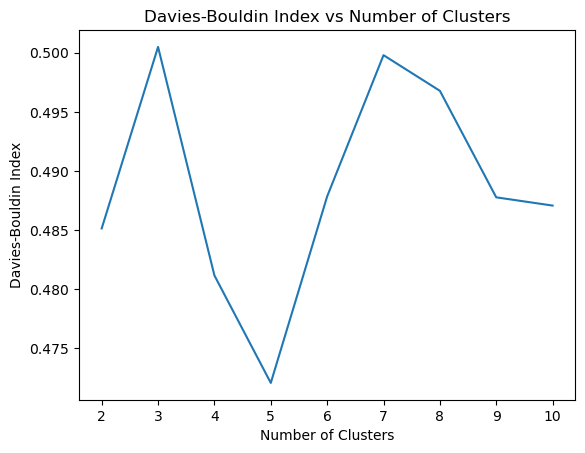

In [541]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

dbi_scores = []

for k in range(2, 11):  # Cluster range from 2 to 10
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
    clusters = kmeans.fit_predict(rfm_scaled_df)
    dbi_score = davies_bouldin_score(rfm_scaled_df, clusters)
    dbi_scores.append(dbi_score)

plt.figure()
plt.plot(range(2, 11), dbi_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.show()


### Looks like 4-5 clusters is ideal

In [542]:
from sklearn.cluster import KMeans

# Number of clusters
num_clusters = 5

# Initialize KMeans
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=1)

# Fit the model and predict clusters
# Make sure to exclude 'CustomerID' from the clustering process
clusters = kmeans.fit_predict(rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])

# Add the cluster labels to your original DataFrame
rfm_scaled_df['Cluster'] = clusters

# Display the first few rows of your DataFrame
rfm_scaled_df.head()


C:\Users\12039\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



,CustomerID,Recency_scaled,Frequency_scaled,Monetary_scaled,Cluster
0,12348,1.274321,-0.659096,0.208470,2
1,12358,-0.803709,-0.558743,-0.110160,0
2,12362,-0.747546,0.244085,-0.390304,0
3,12371,0.403795,-0.558743,0.354207,0
4,12380,-0.242079,-0.358036,-0.239708,0


In [543]:
# Count the number of points in each cluster
cluster_counts = rfm_scaled_df['Cluster'].value_counts()
cluster_counts

0    521
2    131
1     77
4      7
3      2
Name: Cluster, dtype: int64

In [544]:
# 3D Scatter plot with clusters colored
fig = px.scatter_3d(rfm_scaled_df, x='Recency_scaled', y='Frequency_scaled', z='Monetary_scaled', 
                    color='Cluster',  # This line assigns different colors to different clusters
                    title='3D Scatter Plot of RFM',
                    labels={'Recency': 'Recency_scaled',
                            'Frequency': 'Frequency_scaled',
                            'Monetary': 'Monetary_scaled'})

fig.show()


In [545]:
# Add the DataFrame to the dictionary
add_table_to_dict(rfm_scaled_df, 'rfm_scaled_df', tables)
tables

{'onlineretail_raw': '541909 rows',
 'onlineretail_cleaned': '22183 rows',
 'onlineretail_active_customers': '12840 rows',
 'onlineretail_active_customers_100': '9504 rows',
 'rfm_summary_last_180_days': '738 rows',
 'rfm_scaled_df': '738 rows'}

## Examine Clusters

In [546]:
tables

{'onlineretail_raw': '541909 rows',
 'onlineretail_cleaned': '22183 rows',
 'onlineretail_active_customers': '12840 rows',
 'onlineretail_active_customers_100': '9504 rows',
 'rfm_summary_last_180_days': '738 rows',
 'rfm_scaled_df': '738 rows'}

In [547]:
onlineretail_active_customers_100.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceAmount
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01,3.75,12583,France,90.00
82,536376,22114,HOT WATER BOTTLE TEA AND SYMPATHY,48,2010-12-01,3.45,15291,United Kingdom,165.60
86,536378,22386,JUMBO BAG PINK POLKADOT,10,2010-12-01,1.95,14688,United Kingdom,19.50
106,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23,2010-12-01,4.25,15311,United Kingdom,97.75
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311,United Kingdom,-4.65


In [548]:
# Add cluster to the transaction table
# Merge to add columns from rfm_scaled_df
merged_data = pd.merge(onlineretail_active_customers_100, 
                       rfm_scaled_df[['CustomerID', 'Cluster', 'Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], 
                       on='CustomerID', 
                       how='left')

# Merge to add columns from rfm_summary_last_180_days
onlineretail_with_clusters = pd.merge(merged_data, 
                             rfm_summary_last_180_days[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Monetary Sum']], 
                             on='CustomerID', 
                             how='left')

# Display the first few rows of the final merged DataFrame
onlineretail_with_clusters.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceAmount,Cluster,Recency_scaled,Frequency_scaled,Monetary_scaled,Recency,Frequency,Monetary,Monetary Sum
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01,3.75,12583,France,90.00,0,-0.775627,0.344438,-0.341464,2,11,27.286364,300.15
1,536376,22114,HOT WATER BOTTLE TEA AND SYMPATHY,48,2010-12-01,3.45,15291,United Kingdom,165.60,0,-0.129753,-0.157329,-0.196831,25,6,59.560000,357.36
2,536378,22386,JUMBO BAG PINK POLKADOT,10,2010-12-01,1.95,14688,United Kingdom,19.50,1,-0.635220,0.745852,-0.300879,7,15,36.342667,545.14
3,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23,2010-12-01,4.25,15311,United Kingdom,97.75,1,-0.831790,5.061048,-0.359030,0,58,23.366724,1355.27
4,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311,United Kingdom,-4.65,1,-0.831790,5.061048,-0.359030,0,58,23.366724,1355.27


In [549]:
onlineretail_with_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9504 entries, 0 to 9503
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   InvoiceNo         9504 non-null   object 
 1   StockCode         9504 non-null   object 
 2   Description       9504 non-null   object 
 3   Quantity          9504 non-null   int64  
 4   InvoiceDate       9504 non-null   object 
 5   UnitPrice         9504 non-null   float64
 6   CustomerID        9504 non-null   int32  
 7   Country           9504 non-null   object 
 8   InvoiceAmount     9504 non-null   float64
 9   Cluster           9504 non-null   int32  
 10  Recency_scaled    9504 non-null   float64
 11  Frequency_scaled  9504 non-null   float64
 12  Monetary_scaled   9504 non-null   float64
 13  Recency           9504 non-null   int64  
 14  Frequency         9504 non-null   int64  
 15  Monetary          9504 non-null   float64
 16  Monetary Sum      9504 non-null   float64


In [550]:
# Add the DataFrame to the dictionary
add_table_to_dict(onlineretail_with_clusters, 'onlineretail_with_clusters', tables)
tables

{'onlineretail_raw': '541909 rows',
 'onlineretail_cleaned': '22183 rows',
 'onlineretail_active_customers': '12840 rows',
 'onlineretail_active_customers_100': '9504 rows',
 'rfm_summary_last_180_days': '738 rows',
 'rfm_scaled_df': '738 rows',
 'onlineretail_with_clusters': '9504 rows'}

## Examine Clusters

In [551]:
# Top 10 items by cluster

# Group by 'Cluster' and 'Description', then aggregate
grouped = onlineretail_with_clusters.groupby(['Cluster', 'Description']).agg({
    'Quantity': 'mean', 
    'UnitPrice': 'mean',
    'InvoiceAmount': 'sum', 
}).rename(columns={'Quantity': 'Avg Quantity', 'InvoiceAmount': 'Total $'})

# Calculate the total invoice amount per cluster
cluster_totals = grouped.groupby(level=0)['Total $'].sum()

# Calculate the percentage contribution for each item
grouped['Percent of Total $'] = grouped['Total $'].div(grouped.index.get_level_values('Cluster').map(cluster_totals)) * 100

# Sort the groups by total invoice amount within each cluster
sorted_grouped = grouped.sort_values(['Cluster', 'Total $'], ascending=[True, False])

# Calculate the cumulative percentage
sorted_grouped['Cumulative %'] = sorted_grouped.groupby(level=0)['Total $'].cumsum().div(sorted_grouped.index.get_level_values('Cluster').map(cluster_totals)) * 100

# Select the top 10 for each cluster by total invoice amount
top_descriptions = sorted_grouped.groupby(level=0).head(10)

# Display the top 10 descriptions for each cluster
top_descriptions

Avg Quantity    UnitPrice  \
Cluster Description                                                     
0       BLACK RECORD COVER FRAME               85.806452     3.424839   
        RABBIT NIGHT LIGHT                     63.186667     1.848000   
        REGENCY CAKESTAND 3 TIER                8.558824    11.929412   
        CHILLI LIGHTS                          30.868421     5.068421   
        DOORMAT KEEP CALM AND COME IN          22.470588     7.290882   
        PAPER CHAIN KIT 50'S CHRISTMAS         44.634146     2.696341   
        PARTY BUNTING                          29.833333     4.661111   
        POSTAGE                                 1.840580    36.525362   
        WHITE HANGING HEART T-LIGHT HOLDER     22.839286     2.807143   
        SOMBRERO                              400.000000     1.250000   
1       WOOD BLACK BOARD ANT WHITE FINISH      69.666667     6.212333   
        REGENCY CAKESTAND 3 TIER               17.615385    11.538462   
        WHITE HANGING HEART T-LIGHT HOLDER    118.741935     2.614516   
        RABBIT NIGHT LIGHT                    136.878788     1.891818   
        POPCORN HOLDER                        543.823529     0.750588   
        RED HANGING HEART T-LIGHT HOLDER      170.888889     2.824444   
        CHILLI LIGHTS                          57.631579     4.513684   
        SET OF 3 REGENCY CAKE TINS             40.653846     4.673077   
        JUMBO BAG RED RETROSPOT                96.958333     1.797500   
        DOORMAT KEEP CALM AND COME IN          44.058824     7.393529   
2       JUMBO BAG RED RETROSPOT               234.444444     1.808889   
        PARTY BUNTING                          90.200000     4.230000   
        SMALL CHINESE STYLE SCISSOR          1642.857143     0.320000   
        EMPIRE DESIGN ROSETTE                3906.000000     0.820000   
        Manual                                -54.363636   469.525455   
        BLACK RECORD COVER FRAME               93.000000     3.480000   
        SET/4 WHITE RETRO STORAGE CUBES        13.200000    34.950000   
        DOORMAT UNION FLAG                     46.000000     7.650000   
        REGENCY CAKESTAND 3 TIER               13.692308     9.700000   
        ANTIQUE SILVER T-LIGHT GLASS          228.000000     1.060000   
3       REGENCY CAKESTAND 3 TIER                7.200000    12.390000   
        CARRIAGE                                1.000000    46.875000   
        CHILLI LIGHTS                          21.750000     4.625000   
        WHITE HANGING HEART T-LIGHT HOLDER     36.000000     2.750000   
        IVORY REFECTORY CLOCK                  18.000000     8.150000   
        PAPER CHAIN KIT 50'S CHRISTMAS         30.666667     2.683333   
        ENAMEL FLOWER JUG CREAM                36.000000     5.450000   
        RUSTIC  SEVENTEEN DRAWER SIDEBOARD      1.000000   165.000000   
        SET OF 3 BUTTERFLY COOKIE CUTTERS     144.000000     1.060000   
        60 CAKE CASES VINTAGE CHRISTMAS       360.000000     0.420000   
4       RABBIT NIGHT LIGHT                   1096.000000     1.790000   
        PAPER CHAIN KIT 50'S CHRISTMAS        816.000000     2.550000   
        CHILLI LIGHTS                         480.000000     4.315000   
        METAL SIGN TAKE IT OR LEAVE IT       1404.000000     2.750000   
        GROW A FLYTRAP OR SUNFLOWER IN TIN    992.000000     1.060000   
        VINTAGE DOILY JUMBO BAG RED          1500.000000     1.790000   
        LARGE RED RETROSPOT WINDMILL          196.000000     1.850000   
        SWEETHEART BIRD HOUSE                 620.000000     3.300000   
        Manual                                  1.000000  2033.100000   
        ANTIQUE HEART SHELF UNIT              150.000000    13.350000   

                                             Total $  Percent of Total $  \
Cluster Description                                                        
0       BLACK RECORD COVER FRAME             9024.96            3.733461   
        RABBIT NIGH

## Statistical Summary of Clusters:

Start by generating statistical summaries for each cluster (mean, median, standard deviation, etc.) for 'Recency', 'Frequency', and 'Monetary' values.
This will give you a basic understanding of the typical behavior of customers in each cluster.

In [552]:
# Calculate Statistical Summaries for Each Cluster
cluster_summaries = onlineretail_with_clusters.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'std', 'min', 'max'],
    'Frequency': ['mean', 'median', 'std', 'min', 'max'],
    'Monetary': ['mean', 'median', 'std', 'min', 'max']
}).reset_index()

# Renaming columns for clarity
cluster_summaries.columns = ['Cluster', 
                             'Recency_mean', 'Recency_median', 'Recency_std', 'Recency_min', 'Recency_max',
                             'Frequency_mean', 'Frequency_median', 'Frequency_std', 'Frequency_min', 'Frequency_max',
                             'Monetary_mean', 'Monetary_median', 'Monetary_std', 'Monetary_min', 'Monetary_max']

cluster_summaries

,Cluster,Recency_mean,Recency_median,Recency_std,Recency_min,Recency_max,Frequency_mean,Frequency_median,Frequency_std,Frequency_min,Frequency_max,Monetary_mean,Monetary_median,Monetary_std,Monetary_min,Monetary_max
0,0,13.933473,10.0,13.223082,0,59,7.851697,8.0,3.192598,1,14,49.995696,28.838929,54.241846,8.810769,613.200000
1,1,4.821550,2.0,7.432730,0,38,28.768447,24.0,13.543154,15,58,88.269799,42.412391,112.539035,7.239091,568.291591
2,2,92.827160,86.0,27.705068,29,176,3.768959,3.0,2.605625,1,11,152.554336,101.000000,159.735746,10.171818,918.000000
3,3,1.000000,1.0,0.000000,1,1,140.441247,168.0,33.424384,100,168,18.379966,29.156964,13.070784,2.565200,29.156964
4,4,9.771429,7.0,13.549660,2,85,4.628571,6.0,1.864304,1,6,1367.439619,1101.466667,534.701457,1101.466667,3861.000000


## Cluster Profiles:

Create a profile for each cluster based on the RFM values. For instance, a cluster with low recency, high frequency, and high monetary value might be labeled as "Loyal High Spenders".
Cluster profiles help in understanding the behavior patterns of different segments.

In [553]:
tables

{'onlineretail_raw': '541909 rows',
 'onlineretail_cleaned': '22183 rows',
 'onlineretail_active_customers': '12840 rows',
 'onlineretail_active_customers_100': '9504 rows',
 'rfm_summary_last_180_days': '738 rows',
 'rfm_scaled_df': '738 rows',
 'onlineretail_with_clusters': '9504 rows'}

In [554]:
#Create rfm summary with cluster and original RMF unscaled values

# Perform the merge operation
rfm_summary_with_cluster = pd.merge(
    rfm_summary_last_180_days, 
    rfm_scaled_df[['CustomerID', 'Cluster']], 
    on='CustomerID', 
    how='left'
)

# Display the first few rows of the merged DataFrame
rfm_summary_with_cluster.head()


,CustomerID,Recency,Frequency,Monetary,Monetary Sum,Cluster
0,12348,75,1,150.0000,150.00,2
1,12358,1,2,78.9000,157.80,0
2,12362,3,10,16.3880,163.88,0
3,12371,44,2,182.5200,365.04,0
4,12380,21,4,49.9925,199.97,0


In [555]:
# Add the DataFrame to the dictionary
add_table_to_dict(rfm_summary_with_cluster, 'rfm_summary_with_cluster', tables)
tables

{'onlineretail_raw': '541909 rows',
 'onlineretail_cleaned': '22183 rows',
 'onlineretail_active_customers': '12840 rows',
 'onlineretail_active_customers_100': '9504 rows',
 'rfm_summary_last_180_days': '738 rows',
 'rfm_scaled_df': '738 rows',
 'onlineretail_with_clusters': '9504 rows',
 'rfm_summary_with_cluster': '738 rows'}

In [556]:
# 3D Scatter plot with clusters colored
fig = px.scatter_3d(rfm_summary_with_cluster, x='Recency', y='Frequency', z='Monetary', 
                    color='Cluster',  # This line assigns different colors to different clusters
                    title='3D Scatter Plot of RFM',
                    labels={'Recency': 'Recency',
                            'Frequency': 'Frequency',
                            'Monetary': 'Monetary'})

fig.show()

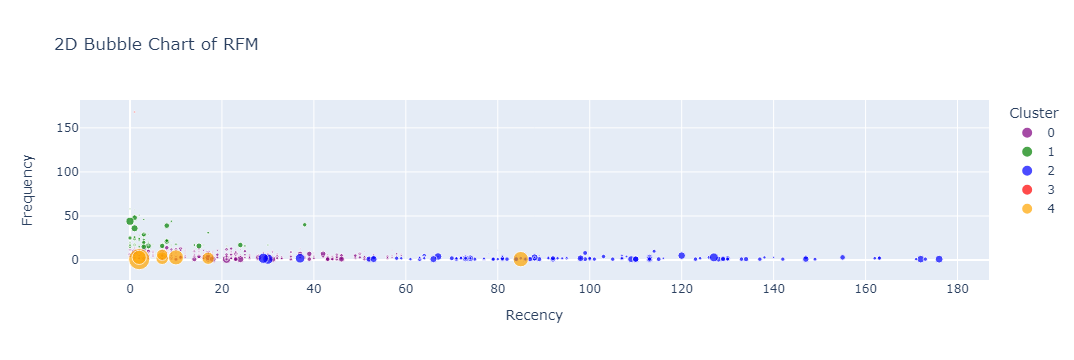

In [557]:
import plotly.express as px

# Convert 'Cluster' to a categorical data type
rfm_summary_with_cluster['Cluster'] = rfm_summary_with_cluster['Cluster'].astype(str)

# Define a custom color palette
custom_color_palette = ['purple', 'green', 'blue', 'red', 'orange']  # Add more colors if you have more clusters

# 2D Bubble chart with ordered clusters in the legend
fig = px.scatter(rfm_summary_with_cluster, x='Recency', y='Frequency', 
                 size='Monetary', color='Cluster', 
                 title='2D Bubble Chart of RFM',
                 labels={'Recency': 'Recency', 'Frequency': 'Frequency', 'Monetary': 'Monetary'},
                 hover_data=['Monetary'],
                 color_discrete_sequence=custom_color_palette,
                 category_orders={"Cluster": ["0", "1", "2", "3", "4"]},
                 size_max=15)  # Specify the order of clusters

fig.show()


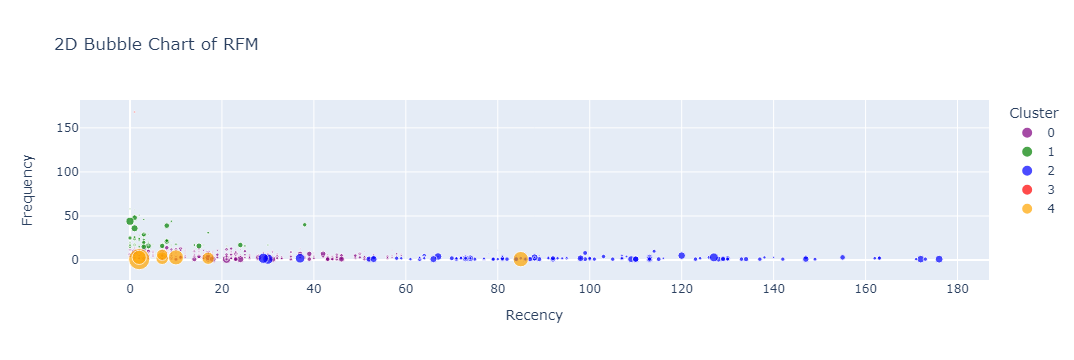

In [558]:
import plotly.express as px

# Convert 'Cluster' to a categorical data type
rfm_summary_with_cluster['Cluster'] = rfm_summary_with_cluster['Cluster'].astype(str)

# Calculate the number of customers in each cluster
cluster_sizes = rfm_summary_with_cluster['Cluster'].value_counts().to_dict()
rfm_summary_with_cluster['Cluster Size'] = rfm_summary_with_cluster['Cluster'].map(cluster_sizes)

# Define a custom color palette
custom_color_palette = ['purple', 'green', 'blue', 'red', 'orange']  # Adjust the colors as needed

# 2D Bubble chart with bigger bubbles and cluster sizes
fig = px.scatter(rfm_summary_with_cluster, x='Recency', y='Frequency', 
                 size='Monetary', color='Cluster', 
                 title='2D Bubble Chart of RFM',
                 labels={'Recency': 'Recency', 'Frequency': 'Frequency', 'Monetary': 'Monetary'},
                 hover_data=['Monetary', 'Cluster Size'],
                 color_discrete_sequence=custom_color_palette,
                 category_orders={"Cluster": ["0", "1", "2", "3", "4"]},
                 size_max=15)  # Increase bubble size

fig.show()


### Possible Cluster names:
**Cluster 0 - "Occasional Shoppers"**: Characterized by low engagement across all RFM metrics. These customers have not made recent purchases, buy infrequently, and spend little when they do.

**Cluster 1 - "Consistent Customers"**: These customers have low recency and high frequency, indicating they make regular purchases, although their spending amounts vary.

**Cluster 2 - "Lapsed Customers"**: They show high recency (haven’t purchased recently), low frequency, and varied monetary values, indicating they are losing engagement.

**Cluster 3 - "Engaged Bargain Shoppers"**: These customers interact very recently and very frequently but spend very little, indicating they may be focused on lower-priced items.

**Cluster 4 - "Big Spenders"**: This group has varied recency and low frequency but very high monetary values, suggesting they make significant purchases but not regularly.

In [559]:
# Define your cluster names based on the criteria
cluster_names = {
    "0": "Occasional Shoppers",
    "1": "Consistent Customers",
    "2": "Lapsed Customers",
    "3": "Engaged Bargain Shoppers",
    "4": "Big Spenders"
}

# Map the cluster numbers to names
rfm_summary_with_cluster['Cluster_name'] = rfm_summary_with_cluster['Cluster'].map(cluster_names)

# Display the first few rows to verify the new column
rfm_summary_with_cluster.head()


,CustomerID,Recency,Frequency,Monetary,Monetary Sum,Cluster,Cluster Size,Cluster_name
0,12348,75,1,150.0000,150.00,2,131,Lapsed Customers
1,12358,1,2,78.9000,157.80,0,521,Occasional Shoppers
2,12362,3,10,16.3880,163.88,0,521,Occasional Shoppers
3,12371,44,2,182.5200,365.04,0,521,Occasional Shoppers
4,12380,21,4,49.9925,199.97,0,521,Occasional Shoppers


In [613]:
tables

{'onlineretail_raw': '541909 rows',
 'onlineretail_cleaned': '22183 rows',
 'onlineretail_active_customers': '12840 rows',
 'onlineretail_active_customers_100': '9504 rows',
 'rfm_summary_last_180_days': '738 rows',
 'rfm_scaled_df': '738 rows',
 'onlineretail_with_clusters': '9504 rows',
 'rfm_summary_with_cluster': '738 rows'}

In [615]:
rfm_scaled_df['Cluster'].unique()

array([2, 0, 1, 4, 3])

In [619]:
# Define your cluster names 
cluster_names = {
    0: "Occasional Shoppers",  
    1: "Consistent Customers",
    2: "Lapsed Customers",
    3: "Engaged Bargain Shoppers",
    4: "Big Spenders"
}

rfm_scaled_df['Cluster'] = rfm_scaled_df['Cluster'].astype(int)

# Map the cluster numbers to names
rfm_scaled_df['Cluster Name'] = rfm_scaled_df['Cluster'].map(cluster_names)

rfm_scaled_df.head()


,CustomerID,Recency_scaled,Frequency_scaled,Monetary_scaled,Cluster,Cluster_name,Cluster Name
0,12348,1.274321,-0.659096,0.208470,2,NaN,Lapsed Customers
1,12358,-0.803709,-0.558743,-0.110160,0,NaN,Occasional Shoppers
2,12362,-0.747546,0.244085,-0.390304,0,NaN,Occasional Shoppers
3,12371,0.403795,-0.558743,0.354207,0,NaN,Occasional Shoppers
4,12380,-0.242079,-0.358036,-0.239708,0,NaN,Occasional Shoppers


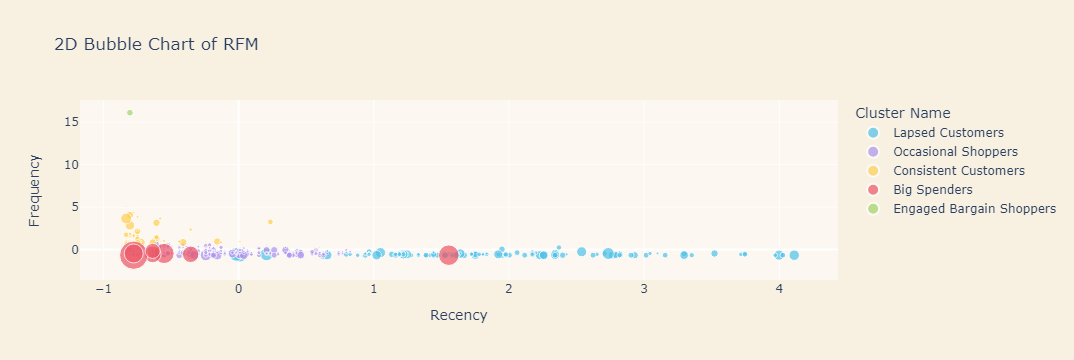

In [639]:
import plotly.express as px
import pandas as pd

# Define your custom color map
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Calculate the size for the bubbles
size_increase_factor = 8  # Adjust as needed
sizes = rfm_scaled_df['Monetary_scaled'] + abs(rfm_scaled_df['Monetary_scaled'].min())
sizes[rfm_scaled_df['Cluster Name'] == 'Engaged Bargain Shoppers'] *= size_increase_factor

# 2D Bubble chart with custom colors and adjusted sizes
fig = px.scatter(
    rfm_scaled_df, 
    x='Recency_scaled', 
    y='Frequency_scaled', 
    size=sizes, 
    color='Cluster Name', 
    title='2D Bubble Chart of RFM', 
    labels={'Recency_scaled': 'Recency', 'Frequency_scaled': 'Frequency', 'size': 'Monetary'},
    hover_data=['Monetary_scaled'],
    color_discrete_map=color_map,
    size_max=20
)


# Update the layout for a lighter background
fig.update_layout({
    'plot_bgcolor': '#fcf7f0', 
    'paper_bgcolor': '#f8f1e2'
})

fig.show()




#### Cluster 4 - "Big Spenders": 
Often considered very important due to their very high monetary value. These customers may make purchases infrequently, but when they do, they spend a lot. They can significantly impact revenue and are typically targeted for exclusive offers and high-value product promotions.

#### Cluster 1 - "Consistent Customers": 
Also important as they represent regular and loyal customers. They may not spend as much per transaction as the "Big Spenders," but their consistent purchases can contribute reliably to revenue. Efforts to increase their transaction value can be beneficial.

#### Cluster 3 - "Engaged Bargain Shoppers": 
They are highly engaged (very low recency and very high frequency) but spend less. They are important for maintaining a steady flow of transactions. Upselling or cross-selling strategies could be effective with this group.

#### Cluster 2 - "Lapsed Customers": 
This group can be a target for re-engagement strategies. They used to purchase in the past but haven't done so recently. Understanding why they have lapsed and addressing these reasons can help in winning them back.

#### Cluster 0 - "Occasional Shoppers": 
Typically the least priority as they show low engagement across all RFM metrics. However, they shouldn't be ignored entirely. Re-engagement campaigns, feedback surveys, or special offers can sometimes reactivate these customers.

## Strategic Focus:
Revenue Maximization: Focus on "Big Spenders" and try to increase the frequency of purchases from "Consistent Customers."
Customer Loyalty and Retention: Focus on "Consistent Customers" and "Engaged Bargain Shoppers," aiming to increase their spending.
Re-engagement: Target "Lapsed Customers" and "Inactive Customers" with reactivation strategies.

## Compare Clusters:

Compare the clusters against each other to understand their relative positions and differences. This can be done through visualizations (like bar charts or line graphs) or tabular comparisons.
This comparison will help in identifying the most and least valuable customer segments.

C:\Users\12039\AppData\Local\Temp\ipykernel_3696\768846926.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



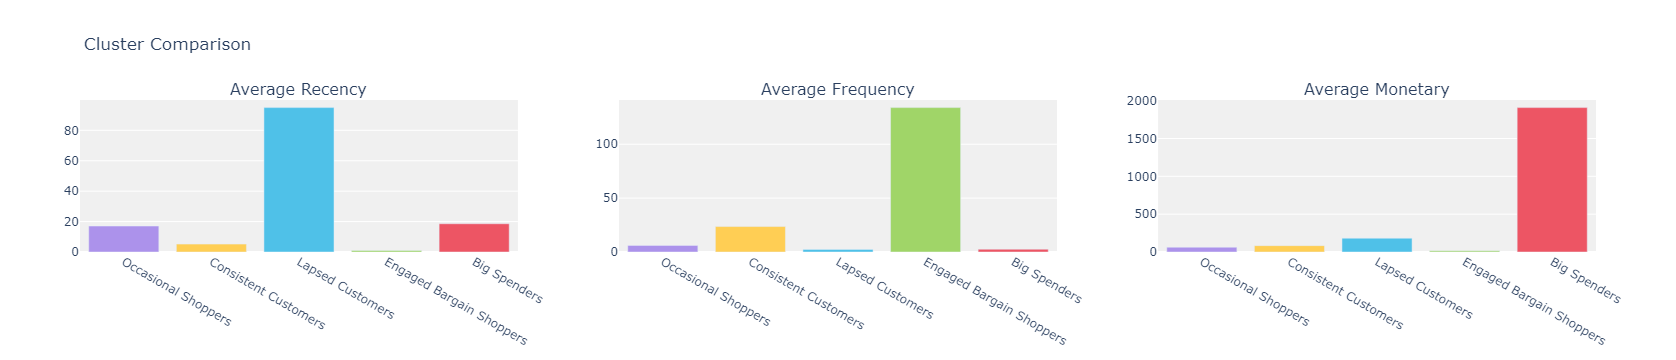

In [561]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Calculate the mean values for each cluster
cluster_means = rfm_summary_with_cluster.groupby('Cluster_name').mean().reset_index()

# Custom color mapping by cluster name
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Apply custom colors to the cluster names
cluster_means['color'] = cluster_means['Cluster_name'].map(color_map)

# Create subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=('Average Recency', 'Average Frequency', 'Average Monetary'))

# Add traces for each metric with custom colors
for col, metric in enumerate(['Recency', 'Frequency', 'Monetary'], start=1):
    for cluster_name, color in color_map.items():
        filtered_data = cluster_means[cluster_means['Cluster_name'] == cluster_name]
        fig.add_trace(
            go.Bar(x=filtered_data['Cluster_name'], y=filtered_data[metric], name=cluster_name, marker_color=color),
            row=1, col=col
        )

# Update layout
fig.update_layout(title_text='Cluster Comparison', showlegend=False)
# Update the layout for a lighter background
fig.update_layout({
    'plot_bgcolor': 'rgba(240, 240, 240, 0.95)',  # Light grey plot background
    'paper_bgcolor': 'rgba(255, 255, 255, 1)',    # White figure background
})
fig.show()



## Cluster Overviews:


In [562]:
#add cluster name to onlineretail_with_clusters by mapping 
cluster_names = {
    "0": "Occasional Shoppers",
    "1": "Consistent Customers",
    "2": "Lapsed Customers",
    "3": "Engaged Bargain Shoppers",
    "4": "Big Spenders"
}


In [563]:
tables

{'onlineretail_raw': '541909 rows',
 'onlineretail_cleaned': '22183 rows',
 'onlineretail_active_customers': '12840 rows',
 'onlineretail_active_customers_100': '9504 rows',
 'rfm_summary_last_180_days': '738 rows',
 'rfm_scaled_df': '738 rows',
 'onlineretail_with_clusters': '9504 rows',
 'rfm_summary_with_cluster': '738 rows'}

In [564]:
# Convert 'Cluster' to string if it's not already
onlineretail_with_clusters['Cluster'] = onlineretail_with_clusters['Cluster'].astype(str)

# Define the cluster name mapping
cluster_names = {
    "0": "Occasional Shoppers",
    "1": "Consistent Customers",
    "2": "Lapsed Customers",
    "3": "Engaged Bargain Shoppers",
    "4": "Big Spenders"
}

# Map the 'Cluster' column to the new 'Cluster Name' column
onlineretail_with_clusters['Cluster Name'] = onlineretail_with_clusters['Cluster'].map(cluster_names)

# Check the first few rows to confirm the changes
onlineretail_with_clusters.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceAmount,Cluster,Recency_scaled,Frequency_scaled,Monetary_scaled,Recency,Frequency,Monetary,Monetary Sum,Cluster Name
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01,3.75,12583,France,90.00,0,-0.775627,0.344438,-0.341464,2,11,27.286364,300.15,Occasional Shoppers
1,536376,22114,HOT WATER BOTTLE TEA AND SYMPATHY,48,2010-12-01,3.45,15291,United Kingdom,165.60,0,-0.129753,-0.157329,-0.196831,25,6,59.560000,357.36,Occasional Shoppers
2,536378,22386,JUMBO BAG PINK POLKADOT,10,2010-12-01,1.95,14688,United Kingdom,19.50,1,-0.635220,0.745852,-0.300879,7,15,36.342667,545.14,Consistent Customers
3,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23,2010-12-01,4.25,15311,United Kingdom,97.75,1,-0.831790,5.061048,-0.359030,0,58,23.366724,1355.27,Consistent Customers
4,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311,United Kingdom,-4.65,1,-0.831790,5.061048,-0.359030,0,58,23.366724,1355.27,Consistent Customers


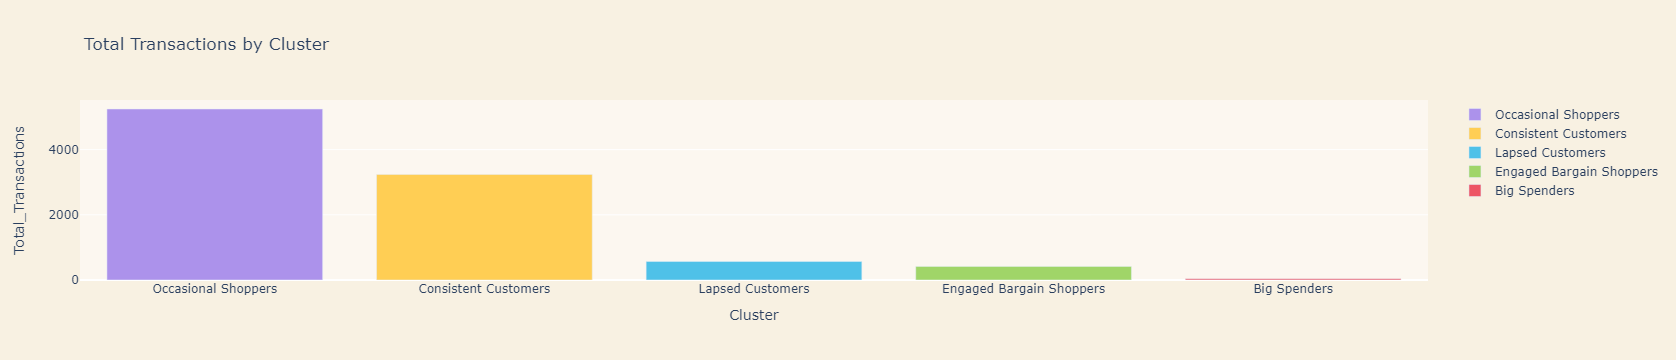

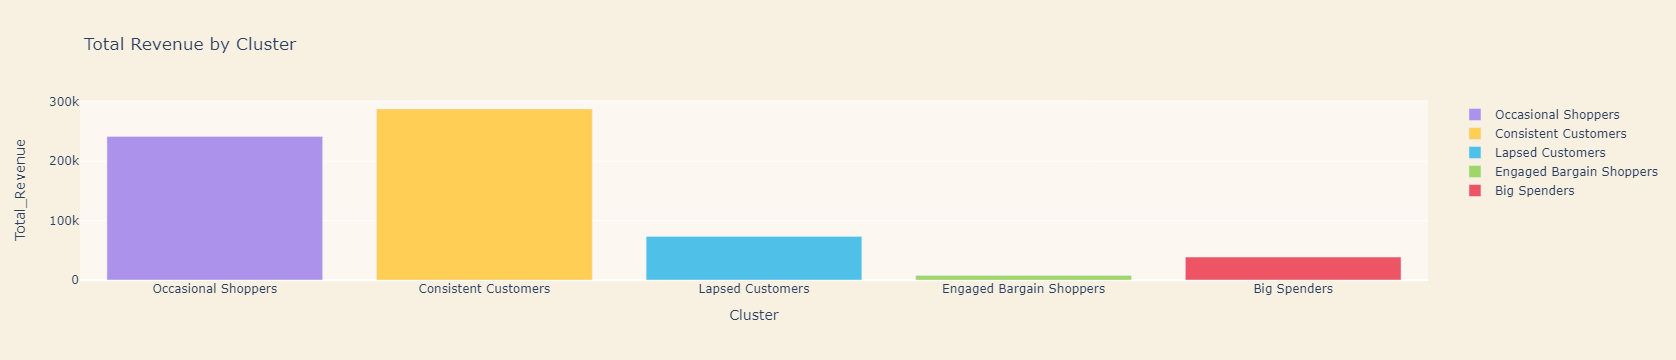

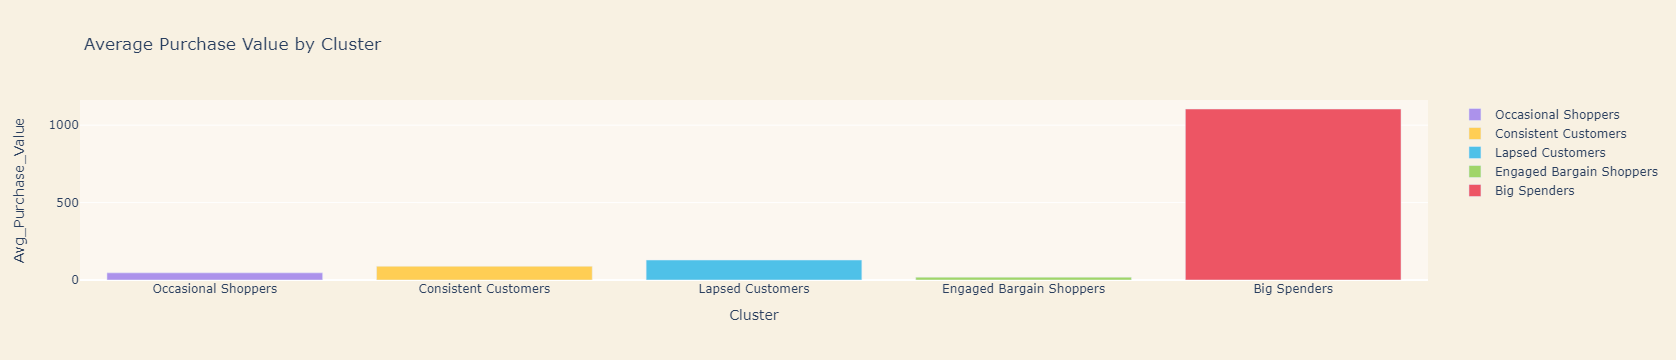

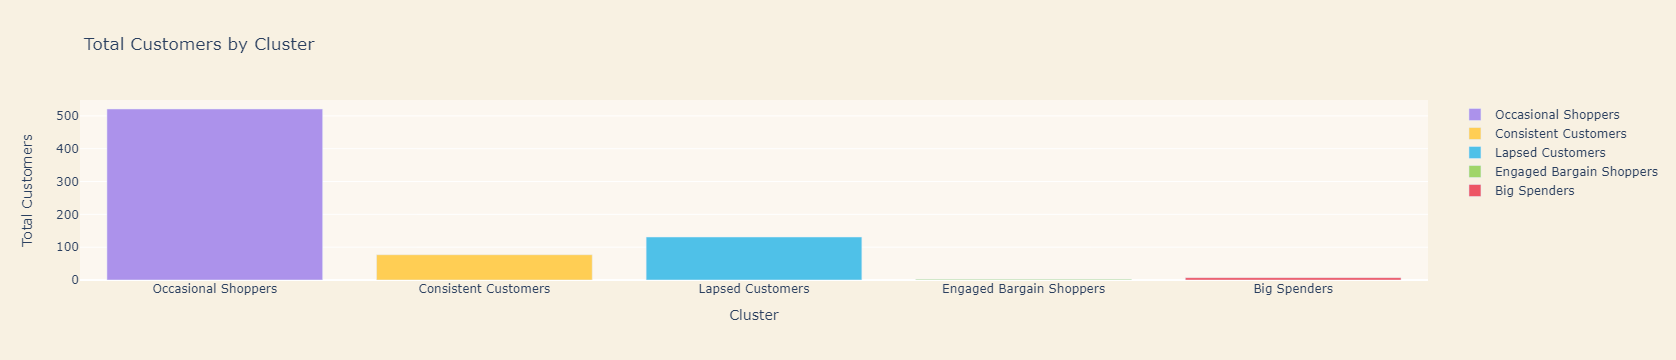

In [637]:
import plotly.graph_objects as go

# Calculate the number of customers in each cluster
customer_counts = onlineretail_with_clusters.groupby('Cluster Name')['CustomerID'].nunique().reset_index(name='Total Customers')

# Merge this with your existing aggregates
cluster_aggregates = cluster_aggregates.merge(customer_counts, on='Cluster Name')

# Custom color mapping by cluster name
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Function to create a bar plot for a given metric
def create_bar_plot(metric, title):
    fig = go.Figure()
    for cluster, color in color_map.items():
        data = cluster_aggregates[cluster_aggregates['Cluster Name'] == cluster]
        fig.add_trace(go.Bar(
            x=[cluster],
            y=data[metric],
            name=cluster,
            marker_color=color
        ))
    fig.update_layout(title=title, xaxis_title="Cluster", yaxis_title=metric, plot_bgcolor='#fcf7f0', paper_bgcolor='#f8f1e2')
    fig.show()

# Create bar plots for each metric including the new 'Total Customers'
create_bar_plot('Total_Transactions', 'Total Transactions by Cluster')
create_bar_plot('Total_Revenue', 'Total Revenue by Cluster')
create_bar_plot('Avg_Purchase_Value', 'Average Purchase Value by Cluster')
create_bar_plot('Total Customers', 'Total Customers by Cluster')



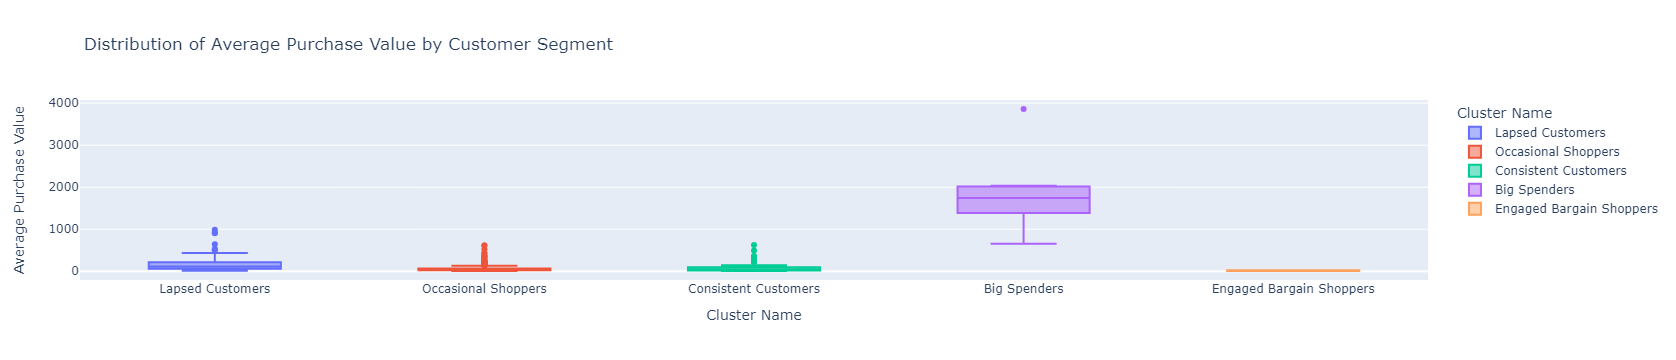

In [650]:
import plotly.express as px

# Calculate the total purchase value per customer
customer_purchase_values = onlineretail_with_clusters.groupby(['CustomerID', 'Cluster Name']).agg(
    Total_Purchase_Value=('InvoiceAmount', 'sum'),
    Total_Transactions=('InvoiceNo', 'nunique')
).reset_index()

# Calculate the average purchase value per customer
customer_purchase_values['Avg_Purchase_Value'] = customer_purchase_values['Total_Purchase_Value'] / customer_purchase_values['Total_Transactions']

# Create a boxplot for each segment
fig = px.box(
    customer_purchase_values,
    x='Cluster Name',
    y='Avg_Purchase_Value',
    color='Cluster Name',
    title='Distribution of Average Purchase Value by Customer Segment',
    labels={'Avg_Purchase_Value': 'Average Purchase Value'}
)

# Show the figure
fig.show()


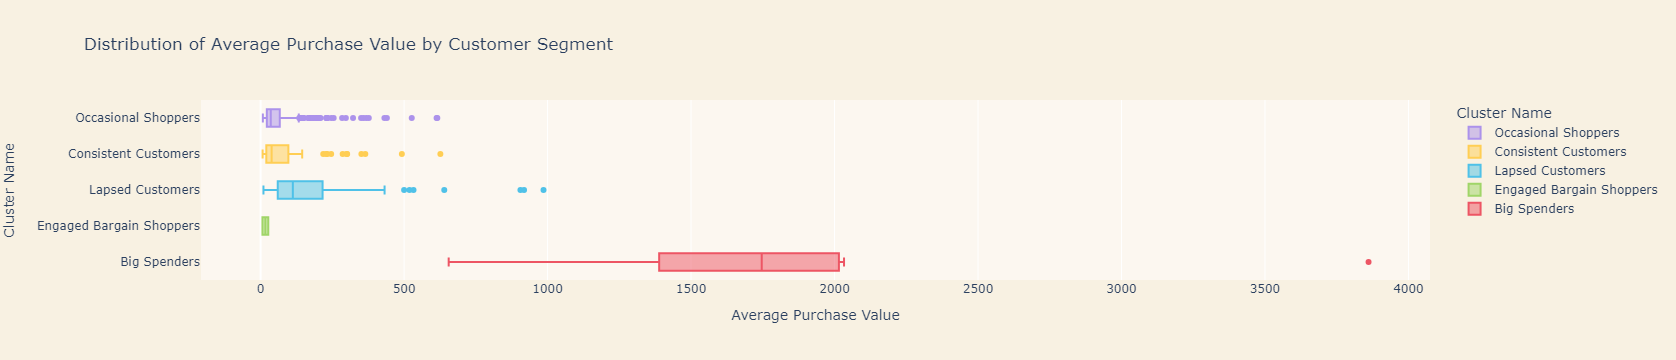

In [657]:
# Calculate the total purchase value per customer
customer_purchase_values = onlineretail_with_clusters.groupby(['CustomerID', 'Cluster Name']).agg(
    Total_Purchase_Value=('InvoiceAmount', 'sum'),
    Total_Transactions=('InvoiceNo', 'nunique')
).reset_index()

# Calculate the average purchase value per customer
customer_purchase_values['Avg_Purchase_Value'] = customer_purchase_values['Total_Purchase_Value'] / customer_purchase_values['Total_Transactions']

# Custom color mapping by cluster name
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Order of clusters as per color_map
cluster_order = list(color_map.keys())

# Create a horizontal boxplot for each segment with custom colors
fig = px.box(
    customer_purchase_values,
    y='Cluster Name',
    x='Avg_Purchase_Value',
    color='Cluster Name',
    title='Distribution of Average Purchase Value by Customer Segment',
    labels={'Avg_Purchase_Value': 'Average Purchase Value'},
    color_discrete_map=color_map,
    category_orders={"Cluster Name": cluster_order}  # Ensuring order matches color_map
)

# Update the layout for a lighter background
fig.update_layout(
    plot_bgcolor='#fcf7f0',  # Light grey plot background
    paper_bgcolor='#f8f1e2'   # White figure background
)

# Show the figure
fig.show()






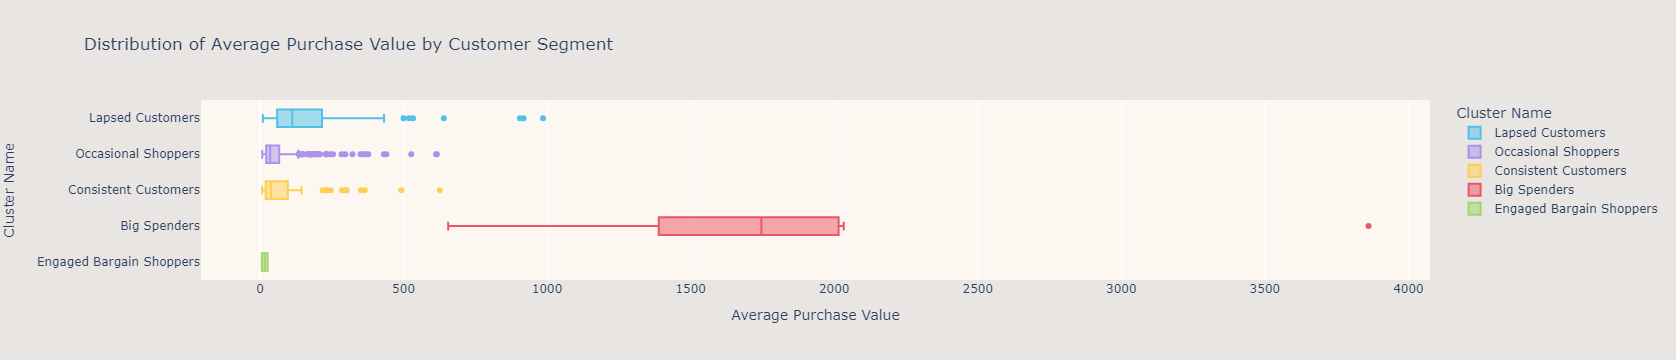

In [656]:
Grey version

# Calculate the total purchase value per customer
customer_purchase_values = onlineretail_with_clusters.groupby(['CustomerID', 'Cluster Name']).agg(
    Total_Purchase_Value=('InvoiceAmount', 'sum'),
    Total_Transactions=('InvoiceNo', 'nunique')
).reset_index()

# Calculate the average purchase value per customer
customer_purchase_values['Avg_Purchase_Value'] = customer_purchase_values['Total_Purchase_Value'] / customer_purchase_values['Total_Transactions']

# Custom color mapping by cluster name
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Create a horizontal boxplot for each segment with custom colors
fig = px.box(
    customer_purchase_values,
    y='Cluster Name',
    x='Avg_Purchase_Value',
    color='Cluster Name',
    title='Distribution of Average Purchase Value by Customer Segment',
    labels={'Avg_Purchase_Value': 'Average Purchase Value'},
    color_discrete_map=color_map
)

# Update the layout for a lighter background
fig.update_layout(
    plot_bgcolor='#fcf7f0',  # Light grey plot background
    paper_bgcolor='#E8E5E2'   # White figure background
)

# Show the figure
fig.show()





In [ ]:
import plotly.graph_objects as go

# Assuming cluster_aggregates is calculated similarly as before, but using rfm_summary_with_cluster
cluster_aggregates = onlineretail_with_clusters.groupby('Cluster Name').agg(
    Total_Transactions=('InvoiceNo', 'nunique'),
    Total_Revenue=('InvoiceAmount', 'sum'),
).reset_index()

# Custom color mapping by cluster name
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Function to create a pie chart for a given metric
def create_pie_chart(metric, title):
    fig = go.Figure(data=[go.Pie(
        labels=cluster_aggregates['Cluster Name'],
        values=cluster_aggregates[metric],
        marker_colors=[color_map[name] for name in cluster_aggregates['Cluster Name']],
        hole=0.3
    )])
    fig.update_layout(title=title)
    fig.show()

# Create pie charts for each metric
create_pie_chart('Total_Transactions', 'Percentage of Total Transactions by Cluster')
create_pie_chart('Total_Revenue', 'Percentage of Total Revenue by Cluster')


In [569]:
rfm_summary_with_cluster

,CustomerID,Recency,Frequency,Monetary,Monetary Sum,Cluster,Cluster Size,Cluster_name
0,12348,75,1,150.000000,150.00,2,131,Lapsed Customers
1,12358,1,2,78.900000,157.80,0,521,Occasional Shoppers
2,12362,3,10,16.388000,163.88,0,521,Occasional Shoppers
3,12371,44,2,182.520000,365.04,0,521,Occasional Shoppers
4,12380,21,4,49.992500,199.97,0,521,Occasional Shoppers
...,...,...,...,...,...,...,...,...
733,18241,9,17,19.275882,327.69,1,77,Consistent Customers
734,18242,72,2,107.070000,214.14,2,131,Lapsed Customers
735,18246,23,1,204.000000,204.00,0,521,Occasional Shoppers
736,18251,87,1,252.000000,252.00,2,131,Lapsed Customers


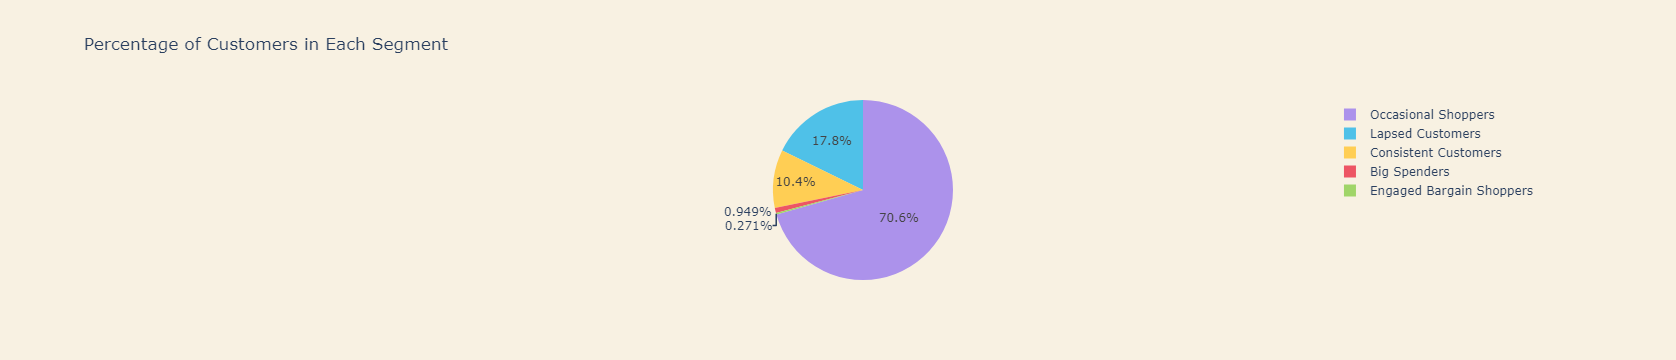

In [599]:
import plotly.graph_objects as go

# Define your custom color map
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Calculate the number of customers in each cluster
cluster_customer_counts = rfm_summary_with_cluster['Cluster_name'].value_counts()

# Prepare colors for each segment
colors = [color_map.get(name, "#000000") for name in cluster_customer_counts.index]  # Default to black if not found

# Create a pie chart
fig = go.Figure(data=[go.Pie(
    labels=cluster_customer_counts.index,
    values=cluster_customer_counts.values,
    marker_colors=colors
)])

# Update the layout for the pie chart
fig.update_layout(title='Percentage of Customers in Each Segment')
fig.update_layout({
    'plot_bgcolor': '#f8f1e2',  # Light grey plot background
    'paper_bgcolor': '#f8f1e2',    # White figure background
    })

fig.show()


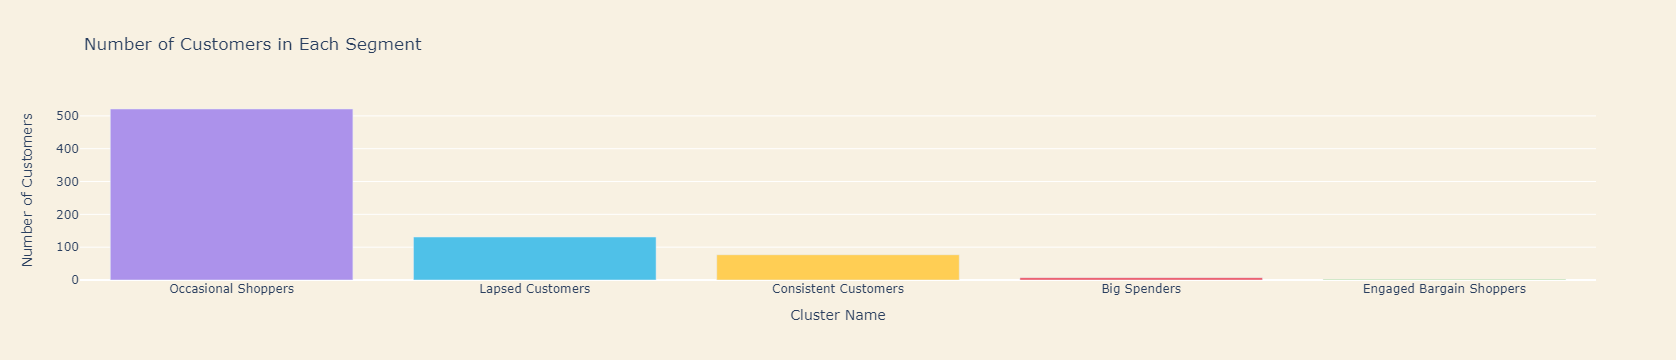

In [600]:
import plotly.graph_objects as go

# Define your custom color map
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Calculate the number of customers in each cluster
cluster_customer_counts = rfm_summary_with_cluster['Cluster_name'].value_counts()

# Prepare colors for each segment
colors = [color_map[name] for name in cluster_customer_counts.index]

# Create a bar chart
fig = go.Figure(data=[go.Bar(
    x=cluster_customer_counts.index,
    y=cluster_customer_counts.values,
    marker_color=colors
)])

# Update the layout for the bar chart
fig.update_layout(
    title='Number of Customers in Each Segment',
    xaxis_title='Cluster Name',
    yaxis_title='Number of Customers',
    plot_bgcolor='#f8f1e2',  # Light grey plot background
    paper_bgcolor='#f8f1e2'  # White figure background
)

fig.show()


In [606]:
onlineretail_with_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9504 entries, 0 to 9503
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   InvoiceNo         9504 non-null   object 
 1   StockCode         9504 non-null   object 
 2   Description       9504 non-null   object 
 3   Quantity          9504 non-null   int64  
 4   InvoiceDate       9504 non-null   object 
 5   UnitPrice         9504 non-null   float64
 6   CustomerID        9504 non-null   int32  
 7   Country           9504 non-null   object 
 8   InvoiceAmount     9504 non-null   float64
 9   Cluster           9504 non-null   object 
 10  Recency_scaled    9504 non-null   float64
 11  Frequency_scaled  9504 non-null   float64
 12  Monetary_scaled   9504 non-null   float64
 13  Recency           9504 non-null   int64  
 14  Frequency         9504 non-null   int64  
 15  Monetary          9504 non-null   float64
 16  Monetary Sum      9504 non-null   float64


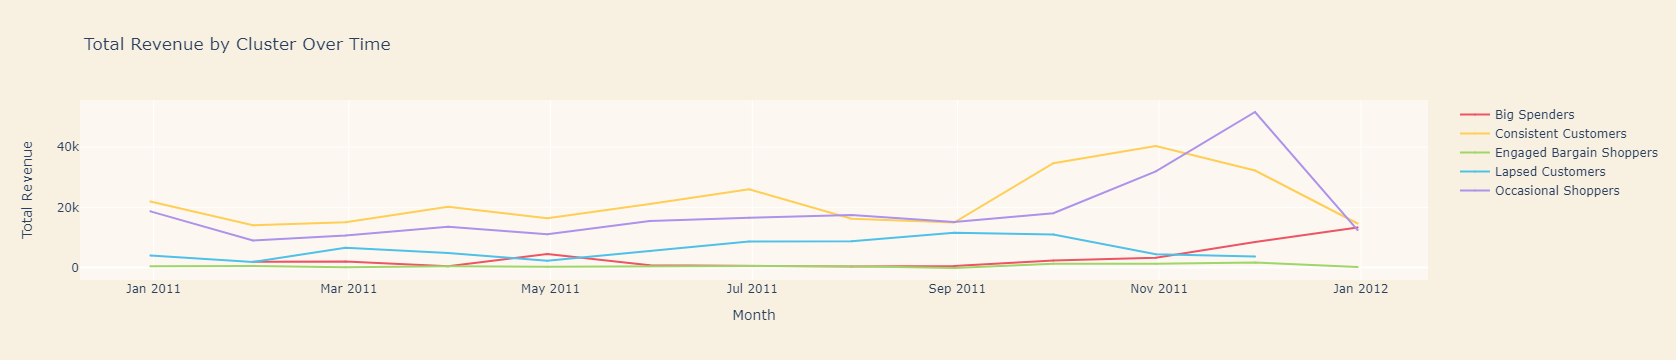

In [646]:
import plotly.graph_objects as go
import pandas as pd

# Assuming you have your DataFrame as 'onlineretail_with_clusters'
# Ensure 'InvoiceDate' is a datetime type
onlineretail_with_clusters['InvoiceDate'] = pd.to_datetime(onlineretail_with_clusters['InvoiceDate'])

# Custom color map for clusters
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Group data by cluster and month, and sum the revenue
monthly_revenue = onlineretail_with_clusters.groupby(['Cluster Name', pd.Grouper(key='InvoiceDate', freq='M')]).agg(
    Total_Revenue=('InvoiceAmount', 'sum')
).reset_index()

# Create a line graph for each cluster
fig = go.Figure()

for cluster in monthly_revenue['Cluster Name'].unique():
    cluster_data = monthly_revenue[monthly_revenue['Cluster Name'] == cluster]
    fig.add_trace(go.Scatter(
        x=cluster_data['InvoiceDate'],
        y=cluster_data['Total_Revenue'],
        mode='lines+markers',
        name=cluster,
        line=dict(color=color_map[cluster]),
        marker=dict(size=2)  # Adjust marker size here, e.g., size 6
    ))

# Update the layout of the figure
fig.update_layout(
    title='Total Revenue by Cluster Over Time',
    xaxis_title='Month',
    yaxis_title='Total Revenue',
    plot_bgcolor='#fcf7f0', 
    paper_bgcolor= '#f8f1e2'
)

# Show the figure
fig.show()



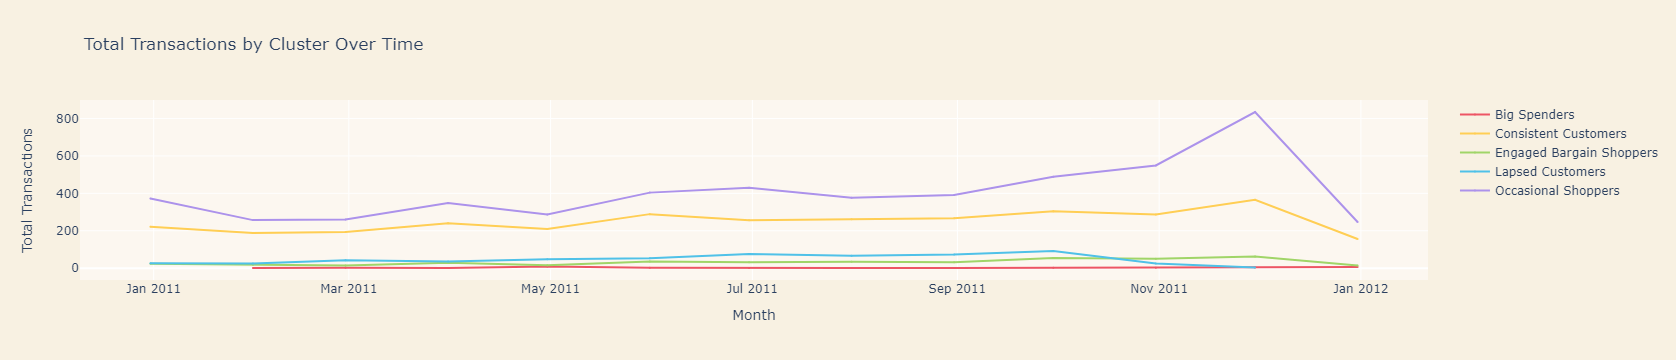

In [648]:
import plotly.graph_objects as go
import pandas as pd

# Assuming you have your DataFrame as 'onlineretail_with_clusters'
# Ensure 'InvoiceDate' is a datetime type
onlineretail_with_clusters['InvoiceDate'] = pd.to_datetime(onlineretail_with_clusters['InvoiceDate'])

# Custom color map for clusters
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Group data by cluster and month, and count the number of transactions
monthly_transactions = onlineretail_with_clusters.groupby(['Cluster Name', pd.Grouper(key='InvoiceDate', freq='M')]).agg(
    Total_Transactions=('InvoiceNo', 'nunique')  # Count unique InvoiceNo for transaction count
).reset_index()

# Create a line graph for each cluster
fig = go.Figure()

for cluster in monthly_transactions['Cluster Name'].unique():
    cluster_data = monthly_transactions[monthly_transactions['Cluster Name'] == cluster]
    fig.add_trace(go.Scatter(
        x=cluster_data['InvoiceDate'],
        y=cluster_data['Total_Transactions'],
        mode='lines+markers',
        name=cluster,
        line=dict(color=color_map[cluster]),
        marker=dict(size=2)
    ))

# Update the layout of the figure
fig.update_layout(
    title='Total Transactions by Cluster Over Time',
    xaxis_title='Month',
    yaxis_title='Total Transactions',
    plot_bgcolor='#fcf7f0', 
    paper_bgcolor= '#f8f1e2'
)

# Show the figure
fig.show()


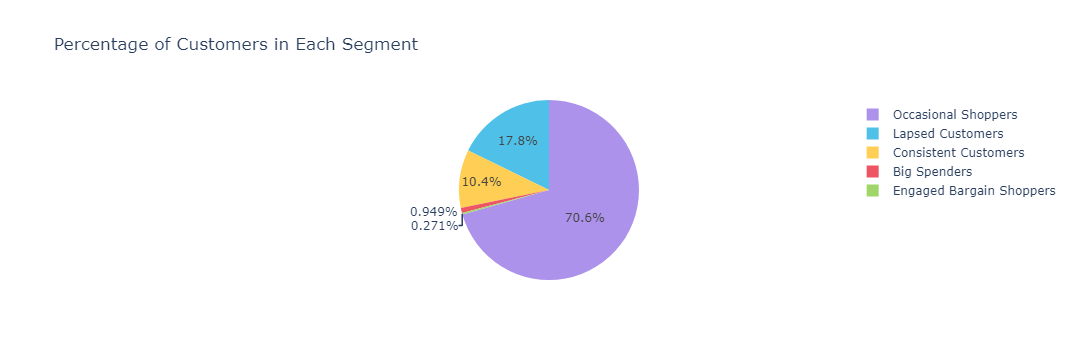

In [590]:
import plotly.graph_objects as go

# Define your custom color map
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Calculate the number of customers in each cluster
cluster_customer_counts = rfm_summary_with_cluster['Cluster_name'].value_counts()

# Prepare colors for each segment
colors = [color_map.get(name, "#000000") for name in cluster_customer_counts.index]  # Default to black if not found

# Create a pie chart
fig = go.Figure(data=[go.Pie(
    labels=cluster_customer_counts.index,
    values=cluster_customer_counts.values,
    marker_colors=colors,
)])

# Update the layout for the pie chart
fig.update_layout(title='Percentage of Customers in Each Segment')

fig.show()


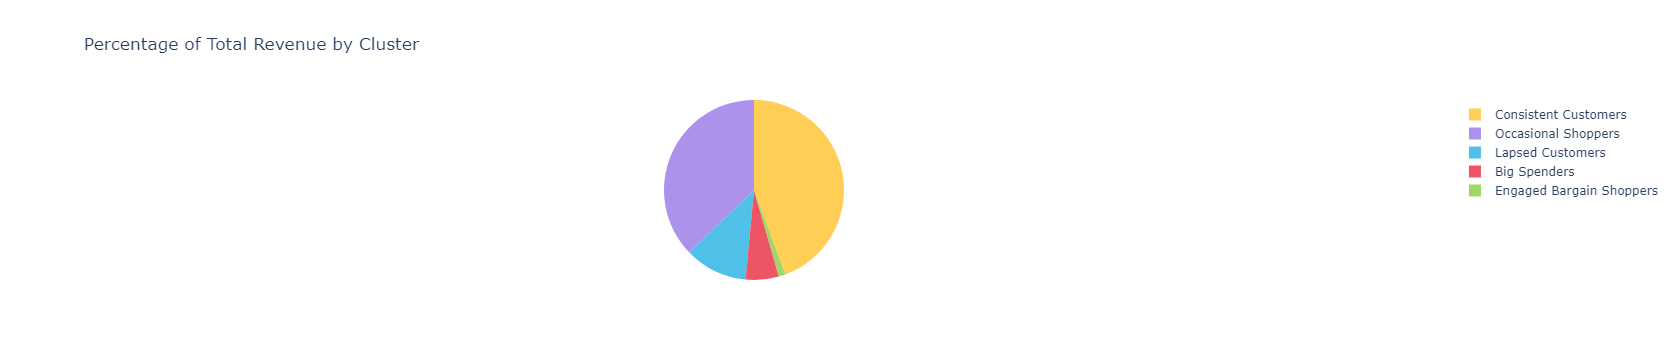

In [582]:
import plotly.graph_objects as go

# Define your custom color map
color_map = {
    "Occasional Shoppers": "#ac92eb",
    "Consistent Customers": "#ffce54",
    "Lapsed Customers": "#4fc1e8",
    "Engaged Bargain Shoppers": "#a0d568",
    "Big Spenders": "#ed5564"
}

# Calculate total revenue for each cluster and its percentage of the total revenue
total_revenue_per_cluster = onlineretail_with_clusters.groupby('Cluster Name')['InvoiceAmount'].sum()
total_revenue = total_revenue_per_cluster.sum()
percent_total_revenue_per_cluster = (total_revenue_per_cluster / total_revenue) * 100

# Prepare colors for each segment
colors = [color_map.get(name, "#000000") for name in percent_total_revenue_per_cluster.index]  # Default to black if not found

# Create a pie chart
fig = go.Figure(data=[go.Pie(
    labels=percent_total_revenue_per_cluster.index,
    values=percent_total_revenue_per_cluster.values,
    marker_colors=colors,
    textinfo='none'  # Hides labels and percentages
)])

# Update the layout for the pie chart
fig.update_layout(title='Percentage of Total Revenue by Cluster')

fig.show()


In [576]:
# Top 10 items by cluster

# Group by 'Cluster' and 'Description', then aggregate
grouped = onlineretail_with_clusters.groupby(['Cluster Name', 'Description']).agg({
    'Quantity': 'mean', 
    'UnitPrice': 'mean',
    'InvoiceAmount': 'sum', 
}).rename(columns={'Quantity': 'Avg Quantity', 'InvoiceAmount': 'Total $'})

# Calculate the total invoice amount per cluster
cluster_totals = grouped.groupby(level=0)['Total $'].sum()

# Calculate the percentage contribution for each item
grouped['Percent of Total $'] = grouped['Total $'].div(grouped.index.get_level_values('Cluster Name').map(cluster_totals)) * 100

# Sort the groups by total invoice amount within each cluster
sorted_grouped = grouped.sort_values(['Cluster Name', 'Total $'], ascending=[True, False])

# Calculate the cumulative percentage
sorted_grouped['Cumulative %'] = sorted_grouped.groupby(level=0)['Total $'].cumsum().div(sorted_grouped.index.get_level_values('Cluster Name').map(cluster_totals)) * 100

# Select the top 10 for each cluster by total invoice amount
top_descriptions = sorted_grouped.groupby(level=0).head(10)

# Display the top 10 descriptions for each cluster
top_descriptions

Avg Quantity  \
Cluster Name             Description                                        
Big Spenders             RABBIT NIGHT LIGHT                   1096.000000   
                         PAPER CHAIN KIT 50'S CHRISTMAS        816.000000   
                         CHILLI LIGHTS                         480.000000   
                         METAL SIGN TAKE IT OR LEAVE IT       1404.000000   
                         GROW A FLYTRAP OR SUNFLOWER IN TIN    992.000000   
                         VINTAGE DOILY JUMBO BAG RED          1500.000000   
                         LARGE RED RETROSPOT WINDMILL          196.000000   
                         SWEETHEART BIRD HOUSE                 620.000000   
                         Manual                                  1.000000   
                         ANTIQUE HEART SHELF UNIT              150.000000   
Consistent Customers     WOOD BLACK BOARD ANT WHITE FINISH      69.666667   
                         REGENCY CAKESTAND 3 TIER               17.615385   
                         WHITE HANGING HEART T-LIGHT HOLDER    118.741935   
                         RABBIT NIGHT LIGHT                    136.878788   
                         POPCORN HOLDER                        543.823529   
                         RED HANGING HEART T-LIGHT HOLDER      170.888889   
                         CHILLI LIGHTS                          57.631579   
                         SET OF 3 REGENCY CAKE TINS             40.653846   
                         JUMBO BAG RED RETROSPOT                96.958333   
                         DOORMAT KEEP CALM AND COME IN          44.058824   
Engaged Bargain Shoppers REGENCY CAKESTAND 3 TIER                7.200000   
                         CARRIAGE                                1.000000   
                         CHILLI LIGHTS                          21.750000   
                         WHITE HANGING HEART T-LIGHT HOLDER     36.000000   
                         IVORY REFECTORY CLOCK                  18.000000   
                         PAPER CHAIN KIT 50'S CHRISTMAS         30.666667   
                         ENAMEL FLOWER JUG CREAM                36.000000   
                         RUSTIC  SEVENTEEN DRAWER SIDEBOARD      1.000000   
                         SET OF 3 BUTTERFLY COOKIE CUTTERS     144.000000   
                         60 CAKE CASES VINTAGE CHRISTMAS       360.000000   
Lapsed Customers         JUMBO BAG RED RETROSPOT               234.444444   
                         PARTY BUNTING                          90.200000   
                         SMALL CHINESE STYLE SCISSOR          1642.857143   
                         EMPIRE DESIGN ROSETTE                3906.000000   
                         Manual                                -54.363636   
                         BLACK RECORD COVER FRAME               93.000000   
                         SET/4 WHITE RETRO STORAGE CUBES        13.200000   
                         DOORMAT UNION FLAG                     46.000000   
                         REGENCY CAKESTAND 3 TIER               13.692308   
                         ANTIQUE SILVER T-LIGHT GLASS          228.000000   
Occasional Shoppers      BLACK RECORD COVER FRAME               85.806452   
                         RABBIT NIGHT LIGHT                     63.186667   
                         REGENCY CAKESTAND 3 TIER                8.558824   
                         CHILLI LIGHTS                          30.868421   
                         DOORMAT KEEP CALM AND COME IN          22.470588   
                         PAPER CHAIN KIT 50'S CHRISTMAS         44.634146   
                         PARTY BUNTING                          29.833333   
                         POSTAGE                                 1.840580   
                         WHITE HANGING HEART T-LIGHT HOLDER     22.839286   
                         SOMBRERO                              400.000000   

                                                        

In [581]:
# Group by 'Cluster Name', then aggregate
grouped_clusters = onlineretail_with_clusters.groupby('Cluster Name').agg({
    'CustomerID': 'nunique',       # Count unique customers
    'InvoiceNo': 'nunique',        # Count unique invoices
    'InvoiceAmount': 'sum',        # Sum total invoice amount
}).rename(columns={'CustomerID': 'Total Customers', 'InvoiceNo': 'Total Transactions', 'InvoiceAmount': 'Total Revenue'})

# Calculate total customers and total transactions across all clusters
total_customers_across_clusters = grouped_clusters['Total Customers'].sum()
total_transactions_across_clusters = grouped_clusters['Total Transactions'].sum()

# Calculate the percentage of total customers and total transactions for each cluster
grouped_clusters['% of Total Customers'] = (grouped_clusters['Total Customers'] / total_customers_across_clusters) * 100
grouped_clusters['% of Total Transactions'] = (grouped_clusters['Total Transactions'] / total_transactions_across_clusters) * 100

# Calculate total revenue per customer
grouped_clusters['Total Revenue per Customer'] = grouped_clusters['Total Revenue'] / grouped_clusters['Total Customers']

# Calculate total revenue across all clusters
total_revenue_across_clusters = grouped_clusters['Total Revenue'].sum()

# Calculate the percentage of total revenue for each cluster
grouped_clusters['% of Total Revenue'] = (grouped_clusters['Total Revenue'] / total_revenue_across_clusters) * 100

# Display the results
grouped_clusters


,Total Customers,Total Transactions,Total Revenue,% of Total Customers,% of Total Transactions,Total Revenue per Customer,% of Total Revenue
Cluster Name,,,,,,,
Big Spenders,7,35,38654.28,0.948509,0.368266,5522.040000,5.954966
Consistent Customers,77,3239,287894.73,10.433604,34.080387,3738.892597,44.352227
Engaged Bargain Shoppers,2,417,7691.51,0.271003,4.387626,3845.755000,1.184932
Lapsed Customers,131,567,73137.74,17.750678,5.965909,558.303359,11.267388
Occasional Shoppers,521,5246,241731.71,70.596206,55.197811,463.976411,37.240486


## Actionable Insights:

### Recommendations
- **Occasional Shoppers**: Targeted marketing to increase purchase frequency.
- **Lapsed Customers**: Personalized outreach for re-engagement.
- **Consistent Customers**: Loyalty programs and exclusive offers.
- **Big Spenders**: Premium services and personalized experiences.
- **Engaged Bargain Shoppers**: Continuous value through deals and community engagement.
